# Credit Risk Resampling Techniques

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from pathlib import Path
from collections import Counter

In [49]:
# dependencies from sklearn
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

In [45]:
# dependencies from imblearn
from imblearn.metrics import classification_report_imbalanced

# Read the CSV and Perform Basic Data Cleaning

In [4]:
# columns list is the list of columns the customer identified as important for machine learning
# Load the data
file_path = Path('./Data/LoanStats_2019Q1.csv')
df = pd.read_csv(file_path)
df.tail()

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,orig_projected_additional_accrued_interest,hardship_payoff_balance_amount,hardship_last_payment_amount,debt_settlement_flag,debt_settlement_flag_date,settlement_status,settlement_date,settlement_amount,settlement_percentage,settlement_term
115672,NaN,NaN,16000.0,16000.0,16000.0,36 months,16.14%,563.62,C,C4,...,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN
115673,NaN,NaN,16000.0,16000.0,16000.0,60 months,11.31%,350.36,B,B3,...,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN
115674,NaN,NaN,29250.0,29250.0,29250.0,60 months,18.94%,757.80,D,D2,...,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN
115675,Total amount funded in policy code 1: 1928448350,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
115676,Total amount funded in policy code 2: 799382986,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
columns = [
    "loan_amnt", "int_rate", "installment", "home_ownership",
    "annual_inc", "verification_status", "issue_d", "loan_status",
    "pymnt_plan", "dti", "delinq_2yrs", "inq_last_6mths",
    "open_acc", "pub_rec", "revol_bal", "total_acc",
    "initial_list_status", "out_prncp", "out_prncp_inv", "total_pymnt",
    "total_pymnt_inv", "total_rec_prncp", "total_rec_int", "total_rec_late_fee",
    "recoveries", "collection_recovery_fee", "last_pymnt_amnt", "next_pymnt_d",
    "collections_12_mths_ex_med", "policy_code", "application_type", "acc_now_delinq",
    "tot_coll_amt", "tot_cur_bal", "open_acc_6m", "open_act_il",
    "open_il_12m", "open_il_24m", "mths_since_rcnt_il", "total_bal_il",
    "il_util", "open_rv_12m", "open_rv_24m", "max_bal_bc",
    "all_util", "total_rev_hi_lim", "inq_fi", "total_cu_tl",
    "inq_last_12m", "acc_open_past_24mths", "avg_cur_bal", "bc_open_to_buy",
    "bc_util", "chargeoff_within_12_mths", "delinq_amnt", "mo_sin_old_il_acct",
    "mo_sin_old_rev_tl_op", "mo_sin_rcnt_rev_tl_op", "mo_sin_rcnt_tl", "mort_acc",
    "mths_since_recent_bc", "mths_since_recent_inq", "num_accts_ever_120_pd", "num_actv_bc_tl",
    "num_actv_rev_tl", "num_bc_sats", "num_bc_tl", "num_il_tl",
    "num_op_rev_tl", "num_rev_accts", "num_rev_tl_bal_gt_0",
    "num_sats", "num_tl_120dpd_2m", "num_tl_30dpd", "num_tl_90g_dpd_24m",
    "num_tl_op_past_12m", "pct_tl_nvr_dlq", "percent_bc_gt_75", "pub_rec_bankruptcies",
    "tax_liens", "tot_hi_cred_lim", "total_bal_ex_mort", "total_bc_limit",
    "total_il_high_credit_limit", "hardship_flag", "debt_settlement_flag"
]

target = ["loan_status"]

print(len(columns))

86


In [6]:
# Load the data
# file_path = Path('LoanStats_2019Q1.csv.zip')
df = df[:-2]
df
loans_df = df.loc[:, columns].copy()
loans_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 115675 entries, 0 to 115674
Data columns (total 86 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   loan_amnt                   115675 non-null  float64
 1   int_rate                    115675 non-null  object 
 2   installment                 115675 non-null  float64
 3   home_ownership              115675 non-null  object 
 4   annual_inc                  115675 non-null  float64
 5   verification_status         115675 non-null  object 
 6   issue_d                     115675 non-null  object 
 7   loan_status                 115675 non-null  object 
 8   pymnt_plan                  115675 non-null  object 
 9   dti                         115418 non-null  float64
 10  delinq_2yrs                 115675 non-null  float64
 11  inq_last_6mths              115675 non-null  float64
 12  open_acc                    115675 non-null  float64
 13  pub_rec       

In [7]:
# Drop the null columns where all values are null
loans_df = loans_df.dropna(axis='columns', how='all')

# Drop the null rows with at least two na
loans_df = loans_df.dropna(thresh=2)

loans_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 115675 entries, 0 to 115674
Data columns (total 86 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   loan_amnt                   115675 non-null  float64
 1   int_rate                    115675 non-null  object 
 2   installment                 115675 non-null  float64
 3   home_ownership              115675 non-null  object 
 4   annual_inc                  115675 non-null  float64
 5   verification_status         115675 non-null  object 
 6   issue_d                     115675 non-null  object 
 7   loan_status                 115675 non-null  object 
 8   pymnt_plan                  115675 non-null  object 
 9   dti                         115418 non-null  float64
 10  delinq_2yrs                 115675 non-null  float64
 11  inq_last_6mths              115675 non-null  float64
 12  open_acc                    115675 non-null  float64
 13  pub_rec       

## Data cleaning to transform the loan_status column into high_risk and low_risk loans

In [8]:
loans_df['loan_status'].value_counts()

Current               94116
Issued                18835
Fully Paid             2157
In Grace Period         233
Late (16-30 days)       155
Late (31-120 days)      138
Charged Off              41
Name: loan_status, dtype: int64

In [9]:
# Remove the `Issued` loan status
# loans having loan_status of "Issued" don't have enough information to make a judgement of high or low risk loan
issued_mask = loans_df['loan_status'] != 'Issued'
loans_df = loans_df.loc[issued_mask]
loans_df

,loan_amnt,int_rate,installment,home_ownership,annual_inc,verification_status,issue_d,loan_status,pymnt_plan,dti,...,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,hardship_flag,debt_settlement_flag
80,35000.0,13.08%,797.80,MORTGAGE,125890.0,Verified,Mar-2019,Fully Paid,n,30.48,...,100.0,80.0,0.0,0.0,399376.0,131350.0,32700.0,130876.0,N,N
82,20000.0,22.50%,769.00,RENT,75000.0,Not Verified,Mar-2019,Current,n,24.37,...,100.0,100.0,0.0,0.0,77797.0,55014.0,47000.0,30797.0,N,N
93,10500.0,17.19%,375.35,RENT,66000.0,Source Verified,Mar-2019,Current,n,27.24,...,85.7,100.0,0.0,0.0,65687.0,38199.0,2000.0,61987.0,N,N
99,25000.0,20.00%,929.09,MORTGAGE,105000.0,Verified,Mar-2019,Current,n,20.23,...,91.2,50.0,1.0,0.0,271427.0,60641.0,41200.0,49197.0,N,N
132,20000.0,20.00%,529.88,MORTGAGE,56000.0,Verified,Mar-2019,Current,n,24.26,...,66.7,50.0,0.0,0.0,60644.0,45684.0,7500.0,43144.0,N,N
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
115670,5000.0,13.56%,169.83,MORTGAGE,48000.0,Not Verified,Jan-2019,Current,n,8.28,...,90.5,NaN,0.0,0.0,88613.0,9182.0,0.0,11413.0,N,N
115671,6000.0,6.46%,183.79,MORTGAGE,96000.0,Not Verified,Jan-2019,Current,n,0.31,...,100.0,0.0,1.0,0.0,33500.0,50.0,14900.0,0.0,N,N
115672,16000.0,16.14%,563.62,MORTGAGE,32000.0,Source Verified,Jan-2019,Current,n,20.89,...,93.3,37.5,1.0,0.0,34200.0,17066.0,16400.0,0.0,N,N
115673,16000.0,11.31%,350.36,MORTGAGE,72000.0,Verified,Jan-2019,Current,n,7.02,...,94.3,0.0,1.0,0.0,251486.0,74835.0,23000.0,63090.0,N,N


In [10]:
loans_df['loan_status'].value_counts()

Current               94116
Fully Paid             2157
In Grace Period         233
Late (16-30 days)       155
Late (31-120 days)      138
Charged Off              41
Name: loan_status, dtype: int64

In [11]:
# Convert the target column values to low_risk and high_risk based on their values
# x = {'Current': 'low_risk'}   
loans_df = loans_df.replace({'Current': 'low_risk', 'Fully Paid': 'low_risk'})
loans_df['loan_status'].value_counts()

low_risk              96273
In Grace Period         233
Late (16-30 days)       155
Late (31-120 days)      138
Charged Off              41
Name: loan_status, dtype: int64

In [12]:
x = dict.fromkeys(['Late (31-120 days)', 'Late (16-30 days)', 'Charged Off', 'In Grace Period'], 'high_risk')    
loans_df = loans_df.replace(x)
loans_df['loan_status'].value_counts()

low_risk     96273
high_risk      567
Name: loan_status, dtype: int64

In [13]:
loans_df.reset_index(inplace=True, drop=True)

loans_df.head()

,loan_amnt,int_rate,installment,home_ownership,annual_inc,verification_status,issue_d,loan_status,pymnt_plan,dti,...,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,hardship_flag,debt_settlement_flag
0,35000.0,13.08%,797.80,MORTGAGE,125890.0,Verified,Mar-2019,low_risk,n,30.48,...,100.0,80.0,0.0,0.0,399376.0,131350.0,32700.0,130876.0,N,N
1,20000.0,22.50%,769.00,RENT,75000.0,Not Verified,Mar-2019,low_risk,n,24.37,...,100.0,100.0,0.0,0.0,77797.0,55014.0,47000.0,30797.0,N,N
2,10500.0,17.19%,375.35,RENT,66000.0,Source Verified,Mar-2019,low_risk,n,27.24,...,85.7,100.0,0.0,0.0,65687.0,38199.0,2000.0,61987.0,N,N
3,25000.0,20.00%,929.09,MORTGAGE,105000.0,Verified,Mar-2019,low_risk,n,20.23,...,91.2,50.0,1.0,0.0,271427.0,60641.0,41200.0,49197.0,N,N
4,20000.0,20.00%,529.88,MORTGAGE,56000.0,Verified,Mar-2019,low_risk,n,24.26,...,66.7,50.0,0.0,0.0,60644.0,45684.0,7500.0,43144.0,N,N


In [14]:
# convert interest rate to numerical
loans_df['int_rate'] = loans_df['int_rate'].str.replace('%', '')
loans_df['int_rate'] = loans_df['int_rate'].astype('float') / 100
loans_df.head()

,loan_amnt,int_rate,installment,home_ownership,annual_inc,verification_status,issue_d,loan_status,pymnt_plan,dti,...,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,hardship_flag,debt_settlement_flag
0,35000.0,0.1308,797.80,MORTGAGE,125890.0,Verified,Mar-2019,low_risk,n,30.48,...,100.0,80.0,0.0,0.0,399376.0,131350.0,32700.0,130876.0,N,N
1,20000.0,0.2250,769.00,RENT,75000.0,Not Verified,Mar-2019,low_risk,n,24.37,...,100.0,100.0,0.0,0.0,77797.0,55014.0,47000.0,30797.0,N,N
2,10500.0,0.1719,375.35,RENT,66000.0,Source Verified,Mar-2019,low_risk,n,27.24,...,85.7,100.0,0.0,0.0,65687.0,38199.0,2000.0,61987.0,N,N
3,25000.0,0.2000,929.09,MORTGAGE,105000.0,Verified,Mar-2019,low_risk,n,20.23,...,91.2,50.0,1.0,0.0,271427.0,60641.0,41200.0,49197.0,N,N
4,20000.0,0.2000,529.88,MORTGAGE,56000.0,Verified,Mar-2019,low_risk,n,24.26,...,66.7,50.0,0.0,0.0,60644.0,45684.0,7500.0,43144.0,N,N


In [15]:
# for machine learning we need all columns to be numeric
# examine those columns that objects
columns_objects = loans_df.select_dtypes(include=['object']).columns
print(len(columns_objects))

10


In [16]:
print(columns_objects)

Index(['home_ownership', 'verification_status', 'issue_d', 'loan_status',
       'pymnt_plan', 'initial_list_status', 'next_pymnt_d', 'application_type',
       'hardship_flag', 'debt_settlement_flag'],
      dtype='object')


In [17]:
# examine the value counts for columns that are objects
for column in loans_df[columns_objects]:
    # print out the column name and the value_counts for each column
    print (column, "\n", loans_df[column].value_counts())
    print("-------------------------------")

# note in the output below that pymnt_plan, hardship_flag, debt_settlement_flag 
# have only one value for the entire column
# these will be removed as they will not provide information for our ML model to learn from 

home_ownership 
 MORTGAGE    48791
RENT        36169
OWN         11106
ANY           773
NONE            1
Name: home_ownership, dtype: int64
-------------------------------
verification_status 
 Not Verified       46175
Source Verified    35514
Verified           15151
Name: verification_status, dtype: int64
-------------------------------
issue_d 
 Jan-2019    43584
Feb-2019    35985
Mar-2019    17271
Name: issue_d, dtype: int64
-------------------------------
loan_status 
 low_risk     96273
high_risk      567
Name: loan_status, dtype: int64
-------------------------------
pymnt_plan 
 n    96840
Name: pymnt_plan, dtype: int64
-------------------------------
initial_list_status 
 w    84817
f    12023
Name: initial_list_status, dtype: int64
-------------------------------
next_pymnt_d 
 May-2019    58390
Apr-2019    36252
Name: next_pymnt_d, dtype: int64
-------------------------------
application_type 
 Individual    83173
Joint App     13667
Name: application_type, dtype: int64
--

In [18]:
# note in the output below that pymnt_plan, hardship_flag, debt_settlement_flag 
# have only one value for the entire column
# these will be removed as they will not provide information for our ML model to learn from 
loans_df = loans_df.drop(columns=['pymnt_plan', 'hardship_flag', 'debt_settlement_flag'])
loans_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 96840 entries, 0 to 96839
Data columns (total 83 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   loan_amnt                   96840 non-null  float64
 1   int_rate                    96840 non-null  float64
 2   installment                 96840 non-null  float64
 3   home_ownership              96840 non-null  object 
 4   annual_inc                  96840 non-null  float64
 5   verification_status         96840 non-null  object 
 6   issue_d                     96840 non-null  object 
 7   loan_status                 96840 non-null  object 
 8   dti                         96638 non-null  float64
 9   delinq_2yrs                 96840 non-null  float64
 10  inq_last_6mths              96840 non-null  float64
 11  open_acc                    96840 non-null  float64
 12  pub_rec                     96840 non-null  float64
 13  revol_bal                   968

In [19]:
# the remaining columns will be considerd as our clean_loans_df
# examine the result of dropping remaining rows that have an na value
# this is the same as na would have been dropped early on in the process
clean_loans_df = loans_df.dropna()
clean_loans_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 68817 entries, 2 to 96838
Data columns (total 83 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   loan_amnt                   68817 non-null  float64
 1   int_rate                    68817 non-null  float64
 2   installment                 68817 non-null  float64
 3   home_ownership              68817 non-null  object 
 4   annual_inc                  68817 non-null  float64
 5   verification_status         68817 non-null  object 
 6   issue_d                     68817 non-null  object 
 7   loan_status                 68817 non-null  object 
 8   dti                         68817 non-null  float64
 9   delinq_2yrs                 68817 non-null  float64
 10  inq_last_6mths              68817 non-null  float64
 11  open_acc                    68817 non-null  float64
 12  pub_rec                     68817 non-null  float64
 13  revol_bal                   688

In [20]:
# save this clean_loans_df as a csv file
clean_loans_df.to_csv('./Data/clean_loans.csv', index=False)

# Split the Data into Training and Testing

In [21]:
df = pd.read_csv('./Data/clean_loans.csv')
df.head()

,loan_amnt,int_rate,installment,home_ownership,annual_inc,verification_status,issue_d,loan_status,dti,delinq_2yrs,...,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit
0,10500.0,0.1719,375.35,RENT,66000.0,Source Verified,Mar-2019,low_risk,27.24,0.0,...,0.0,3.0,85.7,100.0,0.0,0.0,65687.0,38199.0,2000.0,61987.0
1,25000.0,0.2000,929.09,MORTGAGE,105000.0,Verified,Mar-2019,low_risk,20.23,0.0,...,0.0,6.0,91.2,50.0,1.0,0.0,271427.0,60641.0,41200.0,49197.0
2,20000.0,0.2000,529.88,MORTGAGE,56000.0,Verified,Mar-2019,low_risk,24.26,0.0,...,0.0,4.0,66.7,50.0,0.0,0.0,60644.0,45684.0,7500.0,43144.0
3,10000.0,0.1640,353.55,RENT,92000.0,Verified,Mar-2019,low_risk,31.44,0.0,...,0.0,1.0,100.0,50.0,1.0,0.0,99506.0,68784.0,19700.0,76506.0
4,22000.0,0.1474,520.39,MORTGAGE,52000.0,Not Verified,Mar-2019,low_risk,18.76,0.0,...,0.0,1.0,100.0,0.0,0.0,0.0,219750.0,25919.0,27600.0,20000.0


In [28]:
# Create our features
X = df.drop(columns='loan_status')
X.shape

(68817, 82)

In [29]:
# examine the value counts for columns that are objects
columns_objects = X.select_dtypes(include=['object']).columns
for column in X[columns_objects]:
    # print out the column name and the value_counts for each column
    print (column, "\n", X[column].value_counts())
    print("-------------------------------")

# to understand how many rows pd.get_dummies will add - count up all the values below
# note there are six columns with dtype category
# home_ownership = 4
# verification_status = 3
# issued_d = 3
# initial_list_status = 2
# next_pymnt_d = 2
# application_type = 2
# ------------------------
# total 16 (new rows to be added) - 6 (old rows to be removed) = ten new rows 
# new column count should be 82 + 10 = 92


home_ownership 
 MORTGAGE    36219
RENT        24613
OWN          7346
ANY           639
Name: home_ownership, dtype: int64
-------------------------------
verification_status 
 Not Verified       32895
Source Verified    25737
Verified           10185
Name: verification_status, dtype: int64
-------------------------------
issue_d 
 Jan-2019    31041
Feb-2019    25579
Mar-2019    12197
Name: issue_d, dtype: int64
-------------------------------
initial_list_status 
 w    60292
f     8525
Name: initial_list_status, dtype: int64
-------------------------------
next_pymnt_d 
 May-2019    42449
Apr-2019    26368
Name: next_pymnt_d, dtype: int64
-------------------------------
application_type 
 Individual    59206
Joint App      9611
Name: application_type, dtype: int64
-------------------------------


In [30]:
# use get_dummies to convert object dtypes to a numeric
X = pd.get_dummies(X)

X.shape

# note get_dummies added the ten rows

(68817, 92)

In [31]:
# examine to ensure all columns are now numeric
# also examine the rows added using pd.get_dummies (i.e. home_ownership now has four new coluns)
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 68817 entries, 0 to 68816
Data columns (total 92 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   loan_amnt                            68817 non-null  float64
 1   int_rate                             68817 non-null  float64
 2   installment                          68817 non-null  float64
 3   annual_inc                           68817 non-null  float64
 4   dti                                  68817 non-null  float64
 5   delinq_2yrs                          68817 non-null  float64
 6   inq_last_6mths                       68817 non-null  float64
 7   open_acc                             68817 non-null  float64
 8   pub_rec                              68817 non-null  float64
 9   revol_bal                            68817 non-null  float64
 10  total_acc                            68817 non-null  float64
 11  out_prncp                   

In [32]:
# Create our target
y = df['loan_status']
y.value_counts()

# note this is an imbalanced problem as there are very few high_risk loans to train the model 

low_risk     68470
high_risk      347
Name: loan_status, dtype: int64

In [33]:
# from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

In [59]:
y_train_value_counts = y_train.value_counts()
print(y_train_value_counts)

low_risk     51366
high_risk      246
Name: loan_status, dtype: int64


In [65]:
# calculate the percentage of high_risk loans in the training set
percentage_high_risk_loans = y_train_value_counts[1]/y_train_value_counts[0]
print(f"The percentage of high_risk loans available to train on is: {round(percentage_high_risk_loans, 4):.2}%")

The percentage of high_risk loans available to train on is: 0.0048%


### establish a benchmark: evalute the module without resampling using Logistic Regression

In [ ]:
X.describe()

In [ ]:
# Check the balance of our target values
y['loan_status'].value_counts()

In [51]:
# Display the confusion matrix
# from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)
print(cm)

[[    1   100]
 [    2 17102]]


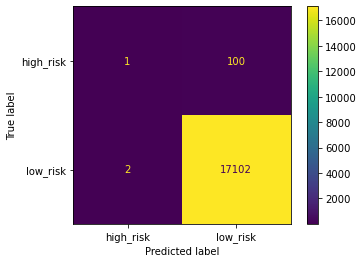

In [53]:
# display the confusion matrix display
# from sklearn.metrics import ConfusionMatrixDisplay
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels= model.classes_)
disp.plot()
# plt.savefig("./Images/LogisticRegress_No_sampling.png")
plt.show()

In [66]:
# Print the balanced classification report
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

   high_risk       0.33      0.01      0.02       101
    low_risk       0.99      1.00      1.00     17104

    accuracy                           0.99     17205
   macro avg       0.66      0.50      0.51     17205
weighted avg       0.99      0.99      0.99     17205



In [67]:
# Print the imbalanced classification report
# from imblearn.metrics import classification_report_imbalanced
print(classification_report_imbalanced(y_test, y_pred))

                   pre       rec       spe        f1       geo       iba       sup

  high_risk       0.33      0.01      1.00      0.02      0.10      0.01       101
   low_risk       0.99      1.00      0.01      1.00      0.10      0.01     17104

avg / total       0.99      0.99      0.02      0.99      0.10      0.01     17205



### Examine potential improvements in modeling using oversampling to create more high_risk loans for the model to train on.

# Oversampling

In this section, you will compare two oversampling algorithms to determine which algorithm results in the best performance. You will oversample the data using the naive random oversampling algorithm and the SMOTE algorithm. For each algorithm, be sure to complete the folliowing steps:

1. View the count of the target classes using `Counter` from the collections library. 
3. Use the resampled data to train a logistic regression model.
3. Calculate the balanced accuracy score from sklearn.metrics.
4. Print the confusion matrix from sklearn.metrics.
5. Generate a classication report using the `imbalanced_classification_report` from imbalanced-learn.

Note: Use a random state of 1 for each sampling algorithm to ensure consistency between tests

### Naive Random Oversampling

In [ ]:
# Resample the training data with the RandomOversampler
# YOUR CODE HERE

In [ ]:
# Train the Logistic Regression model using the resampled data
# YOUR CODE HERE

In [ ]:
# Calculated the balanced accuracy score
# YOUR CODE HERE

In [ ]:
# Display the confusion matrix
# YOUR CODE HERE

In [ ]:
# Print the imbalanced classification report
# YOUR CODE HERE

### SMOTE Oversampling

In [ ]:
# Resample the training data with SMOTE
# YOUR CODE HERE

In [36]:
# Train the Logistic Regression model using the training data
model = LogisticRegression(solver='lbfgs', random_state=1)
model.fit(X_train, y_train)

LogisticRegression(random_state=1)

In [42]:
# Calculated the balanced accuracy score
# from sklearn.metrics import balanced_accuracy_score

# calculate y_predict using the model.predict(X_test)
y_pred = model.predict(X_test)

# calculate the balanced accuracy score using y_test and y_pred
benchmark_score = balanced_accuracy_score(y_test, y_pred)
print(f"The 'benchmark' accuracy score is: {round(benchmark_score, 4)} using a logistics regression model without over or under sampling")

The 'benchmark' accuracy score is: 0.5049 using a logistics regression model without over or under sampling


In [ ]:
# Display the confusion matrix
# YOUR CODE HERE

In [ ]:
# Print the imbalanced classification report
# YOUR CODE HERE

# Undersampling

In this section, you will test an undersampling algorithms to determine which algorithm results in the best performance compared to the oversampling algorithms above. You will undersample the data using the Cluster Centroids algorithm and complete the folliowing steps:

1. View the count of the target classes using `Counter` from the collections library. 
3. Use the resampled data to train a logistic regression model.
3. Calculate the balanced accuracy score from sklearn.metrics.
4. Print the confusion matrix from sklearn.metrics.
5. Generate a classication report using the `imbalanced_classification_report` from imbalanced-learn.

Note: Use a random state of 1 for each sampling algorithm to ensure consistency between tests

In [ ]:
# Resample the data using the ClusterCentroids resampler
# Warning: This is a large dataset, and this step may take some time to complete
# YOUR CODE HERE

In [ ]:
# Train the Logistic Regression model using the resampled data
# YOUR CODE HERE

In [ ]:
# Calculated the balanced accuracy score
# YOUR CODE HERE

In [ ]:
# Display the confusion matrix
# YOUR CODE HERE

In [ ]:
# Print the imbalanced classification report
# YOUR CODE HERE

# Combination (Over and Under) Sampling

In this section, you will test a combination over- and under-sampling algorithm to determine if the algorithm results in the best performance compared to the other sampling algorithms above. You will resample the data using the SMOTEENN algorithm and complete the folliowing steps:

1. View the count of the target classes using `Counter` from the collections library. 
3. Use the resampled data to train a logistic regression model.
3. Calculate the balanced accuracy score from sklearn.metrics.
4. Print the confusion matrix from sklearn.metrics.
5. Generate a classication report using the `imbalanced_classification_report` from imbalanced-learn.

Note: Use a random state of 1 for each sampling algorithm to ensure consistency between tests

In [ ]:
# Resample the training data with SMOTEENN
# Warning: This is a large dataset, and this step may take some time to complete
# YOUR CODE HERE

In [ ]:
# Train the Logistic Regression model using the resampled data
# YOUR CODE HERE

In [ ]:
# Calculated the balanced accuracy score
# YOUR CODE HERE

In [ ]:
# Display the confusion matrix
# YOUR CODE HERE

In [ ]:
# Print the imbalanced classification report
# YOUR CODE HERE